In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn
from transformers import BertModel, BertTokenizer, pipeline
import re, gc, os
import requests
from tqdm.auto import tqdm
import __init__

/z/home/sgal/miniconda3/envs/thermoPML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.BERTembeddings import BERTembeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer


path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ProtBERT.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ProtBERT.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ProtBERT.pth'


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BERT = BERTembeddings(type_embedding = "Rostlab/prot_bert", device = device)
Trainer = Trainer()

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
splits_meltome['sequence']=splits_meltome['sequence'].str.join(" ")
train, val, test = train_test_validation_splits(splits_meltome)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

    batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                test.sequence.to_list(), 
                                                                                val.sequence.to_list(), 
                                                                                batch_size=16)
    print ("Creating Embeddings...")   
    train_embeddings = BERT.embed_dataset(batch_train)
    torch.save(train_embeddings, path_train)
    test_embeddings = BERT.embed_dataset(batch_test)
    torch.save(test_embeddings, path_test)
    val_embeddings = BERT.embed_dataset(batch_val)
    torch.save(val_embeddings, path_val)
    print ("Loaded")
else:
    print ("Loading Premade Embeddings...")
    train_embeddings = torch.load(path_train)
    test_embeddings = torch.load(path_test)
    val_embeddings = torch.load(path_val)
    print ("Loaded")
    
train_loader = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy() ), batch_size=50)
test_loader = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy() ), batch_size=50)
val_loader = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy() ), batch_size=50)

Loading Premade Embeddings...
Loaded


In [4]:
model = regressionHead(train_embeddings.shape[1::])
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss= torch.nn.MSELoss()
epochs = 200
model, val_loss = Trainer.train_LLMRegresor(train_loader, val_loader, model, device, loss, opt, epochs)

epoch: 1 loss: 1265.094 val loss: 1199.475
epoch: 2 loss: 468.377 val loss: 522.876
epoch: 3 loss: 399.550 val loss: 232.185
epoch: 4 loss: 108.975 val loss: 137.035
epoch: 5 loss: 133.122 val loss: 115.318
epoch: 6 loss: 101.278 val loss: 112.999
epoch: 7 loss: 125.798 val loss: 112.407
epoch: 8 loss: 157.240 val loss: 112.947
epoch: 9 loss: 96.081 val loss: 112.855
epoch: 10 loss: 123.289 val loss: 112.278
epoch: 11 loss: 110.289 val loss: 112.357
epoch: 12 loss: 100.163 val loss: 110.192
epoch: 13 loss: 55.536 val loss: 95.468
epoch: 14 loss: 111.053 val loss: 83.170
epoch: 15 loss: 66.879 val loss: 71.729
epoch: 16 loss: 84.650 val loss: 62.738
epoch: 17 loss: 75.015 val loss: 57.035
epoch: 18 loss: 40.200 val loss: 52.726
epoch: 19 loss: 73.704 val loss: 50.253
epoch: 20 loss: 38.505 val loss: 48.595
epoch: 21 loss: 32.142 val loss: 47.743
epoch: 22 loss: 44.877 val loss: 46.479
epoch: 23 loss: 45.027 val loss: 46.361
epoch: 24 loss: 42.579 val loss: 45.770
epoch: 25 loss: 38.585 

MSE: tensor(37.8982, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.1561, device='cuda:0', grad_fn=<SqrtBackward0>)


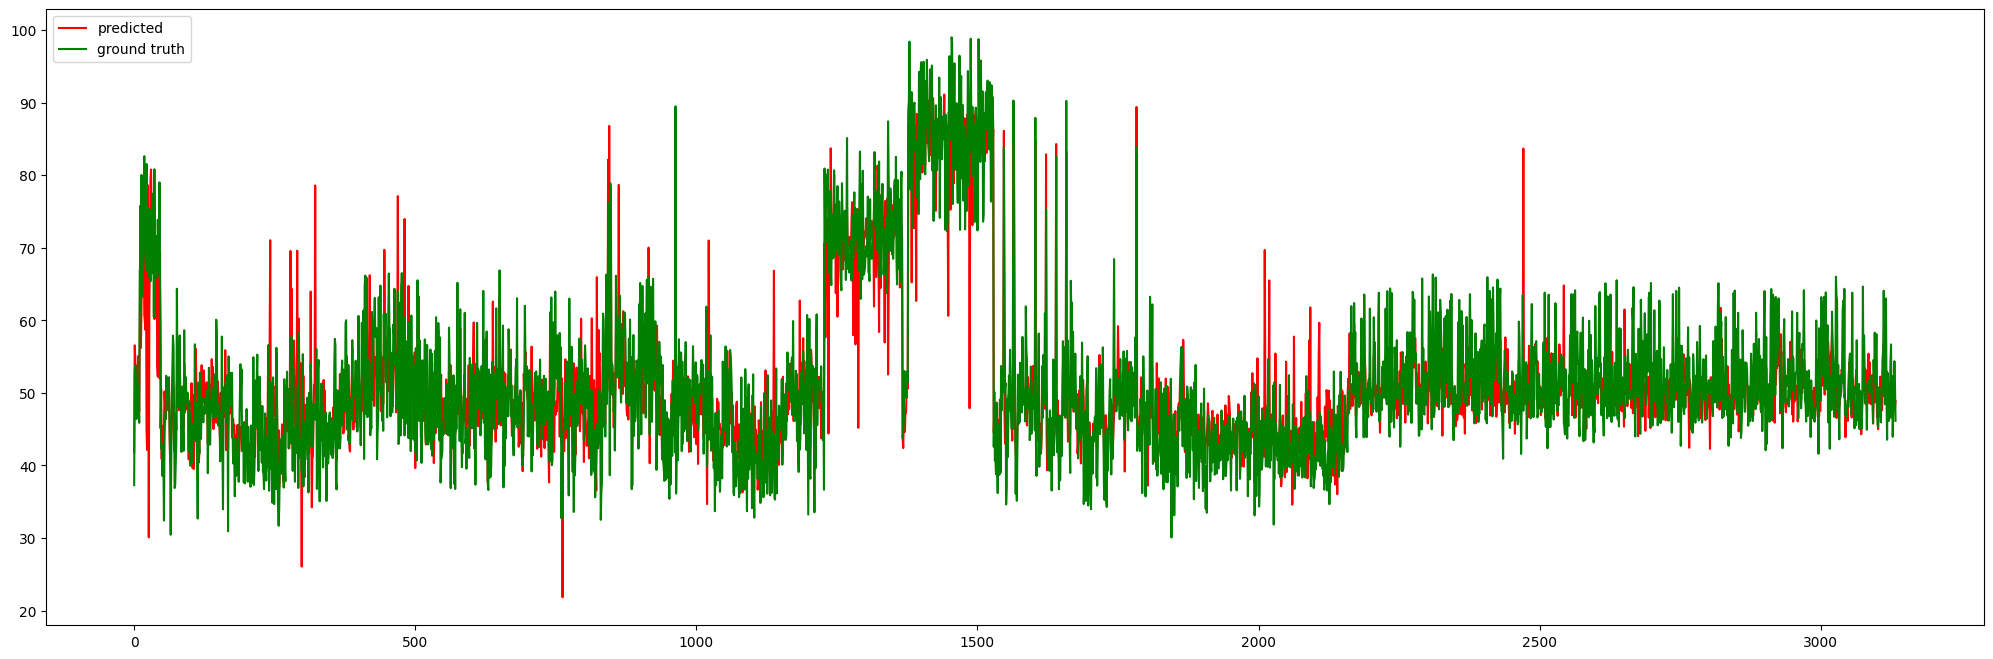

In [5]:
test_set, test_labels = test_loader.dataset.tensors
loss_test, outcome = Trainer.test_model(model, test_set, test_labels, loss, device)
from src.utilities import plot_results

plot_results( outcome, test_labels) 